## Dependencias

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm

from sklearn.decomposition import RandomizedPCA
from sklearn.metrics import accuracy_score

%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Configurações para baixar arquivos do Google Drive

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Clonar o repositório do projeto

In [0]:
%cd /content/
!git clone https://github.com/Larissa13/MAC5749.git
%cd MAC5749

import sys
if not 'MAC5749' in sys.path:
  sys.path.append('MAC5749')

/content
fatal: destination path 'MAC5749' already exists and is not an empty directory.
/content/MAC5749


## Carregar o dataset

In [0]:
from sarpy.datasets import load_emnist

X_train, y_train, X_test, y_test, X_valid, y_valid, mapping, nb_classes = load_emnist('balanced')

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

#print('X_valid shape:', X_valid.shape)
#print('y_valid shape:', y_valid.shape)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

reshape testing: 100%|██████████| 18800/18800 [00:00<00:00, 47341.39it/s]


Train size: 112800
Test size: 18800
Validation size: 0
# classes: 47
X_train shape: (112800, 28, 28, 1)
y_train shape: (112800, 1)
X_test shape: (18800, 28, 28, 1)
y_test shape: (18800, 1)


# Função que avalia os classificadores



In [0]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score

def testClassifiers(X, Y, step):
    names = ["Linear SVM", 
             "RBF SVM",
             "RBF SVM Gamma=2",
             "RBF SVM C=005",
            ]

    classifiers = [
        LinearSVC(C=0.025),
        SVC(kernel="rbf"),
        SVC(kernel="rbf", gamma=2, C=1),
        SVC(kernel="rbf", C=0.005),
    ]

    kfolds   = 4 # number of kfolds

    #print("Kfolds",kfolds)
    
    X_std = X
    #print(X_std.shape)
    
    plt.figure(figsize=(8,8))
    
    # iterate over classifiers names and configurations
    print("\n>> Classifiers")
    print("cross validation, kfolds = ",kfolds,"\n")
    for name, clf in zip(names, classifiers):
        print("+",name)
        #plot x and y
        x_graph = [0]
        y_graph =[[0,0]]

        # increase number of features at each iteration for comparations
        for j in tqdm(range (0,X_std.shape[1],step), desc="Evaluating %s..."%name):
            #print(j+2, "features")
            ttx = X_std[:,:j+2]
            
            #Cross validation 5-folds  (5 classifications)   
            #print(ttx.shape)
            scores = cross_val_score(clf, ttx, Y, cv=kfolds)

            #add results to plot
            x_graph = np.append(x_graph , (j+2))
            y_graph = np.concatenate((y_graph,[[np.mean(scores),np.std(scores)]]),axis=0)

        y_graph = y_graph[1:]
        x_graph = x_graph[1:]

        plt.plot(x_graph,y_graph[:,0],label=name)
        plt.legend()
    plt.xlabel('# of features')
    plt.ylabel('predictions accuracy (%)')
    plt.show()

# SVM direto nos dados

Treinamento de diversos modelos de SVMs diretamente no valor dos pixels, variando a quantidade de dados.

Evaluating Linear SVM...:   0%|          | 0/2 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:   0%|          | 0/2 [00:00<?, ?it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   0%|          | 0/2 [00:00<?, ?it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   0%|          | 0/2 [00:00<?, ?it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


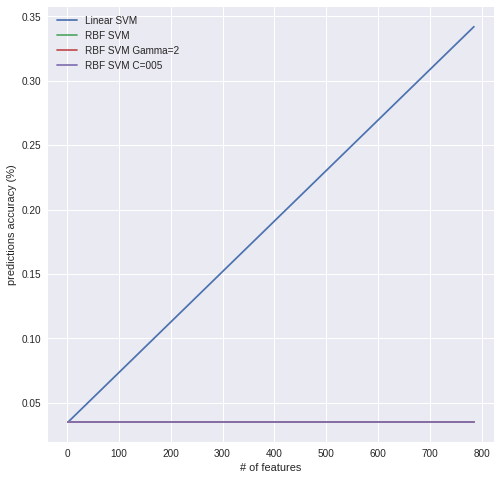

In [0]:
testClassifiers(X_train[0:400].reshape((-1, 28*28)), y_train[0:400].squeeze(), step = 28*28-1)

# Extração de features com VGG16 (Imagenet)

Treinamento de diversos modelos de SVMs sobre as features extraídas pela rede VGG16 [(Simonyan et al, 2015)](https://arxiv.org/abs/1409.1556), pré-treinada para classificação no Imagenet, variando a quantidade de features utilizadas.

### Instanciar a rede

In [0]:
from keras.applications import vgg16

model_vgg16 = vgg16.VGG16(weights='imagenet', include_top=False)
model_vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool

### Funções para extrair as *VGG16 features* das imagens

In [0]:
def get_features_vgg(img, model, new_sz):
    img = np.stack((img,)*3, axis=-1)
    pimage = Image.fromarray(img.astype('uint8'))
    pimage = pimage.resize((new_sz,new_sz))
    img_data = image.img_to_array(pimage)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = vgg16.preprocess_input(img_data)
    features = model.predict(img_data)
    return features
  
def feature_extraction_vgg(X, model):
    M = []
    for i in tqdm(range(len(X)), desc="Extracting image features using VGG16"):
        if (i%500 == 0):
            print(i)
        features = get_features_vgg(X[i].reshape(28,28), model, 224)
        feature_np = np.array(features)
        M.append(feature_np.flatten())
    M = np.asarray(M)
    print(M.shape)
    return M

### Extrair as *VGG16 features* e avaliar os classificadores

Extracting image features using VGG16:   0%|          | 0/400 [00:00<?, ?it/s]

0


Evaluating Linear SVM...:   0%|          | 0/26 [00:00<?, ?it/s]

(400, 25088)

>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:   0%|          | 0/26 [00:00<?, ?it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   0%|          | 0/26 [00:00<?, ?it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   0%|          | 0/26 [00:00<?, ?it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 26/26 [06:11<00:00, 26.06s/it]


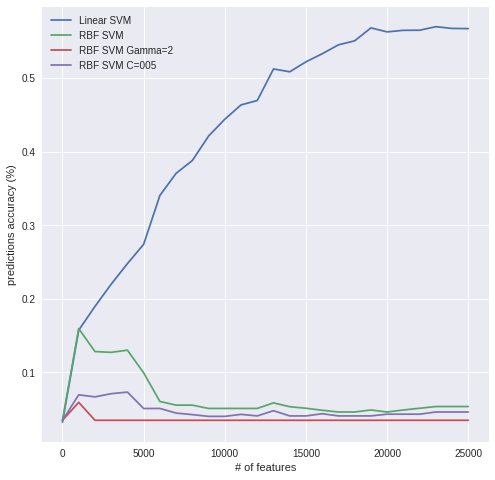

In [0]:
X_train_features_vgg = feature_extraction_vgg(X_train[0:400], model_vgg16)
testClassifiers(X_train_features_vgg[0:400], y_train[0:400].ravel(), 1000)

# Extração de features com Resnet50 (Imagenet)

Treinamento de diversos modelos de SVMs sobre as features extraídas pela rede Resnet50 [(He et al, 2015)](https://arxiv.org/abs/1512.03385) pré-treinada para classificação no Imagenet, variando a quantidade de features utilizadas.

### Instanciar a rede

In [0]:
from keras.applications import resnet50

model_resnet50 = resnet50.ResNet50(weights='imagenet', include_top = False)
model_resnet50.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________

### Funções para extrair as *Resnet50 features* das imagens

In [0]:
def get_features_resnet50(img, model, new_sz):
    img = np.stack((img,)*3, axis=-1)
    pimage = Image.fromarray(img.astype('uint8'))
    pimage = pimage.resize((new_sz,new_sz))
    img_data = image.img_to_array(pimage)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = resnet50.preprocess_input(img_data)
    features = model.predict(img_data)
    return features
  
def feature_extraction_resnet50(X, model):
    M = []
    for i in tqdm(range(len(X)), desc="Extracting image features using Resnet50"):
        features = get_features_resnet50(X[i].reshape(28,28), model, 224)
        feature_np = np.array(features)
        M.append(feature_np.flatten())
    M = np.asarray(M)
    print(M.shape)
    return M

### Extrair as *Resnet50 features* e avaliar os classificadores

Evaluating Linear SVM...:   0%|          | 0/6 [00:00<?, ?it/s]

(400, 100352)

>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:   0%|          | 0/6 [00:00<?, ?it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   0%|          | 0/6 [00:00<?, ?it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   0%|          | 0/6 [00:00<?, ?it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 6/6 [05:45<00:00, 71.94s/it]


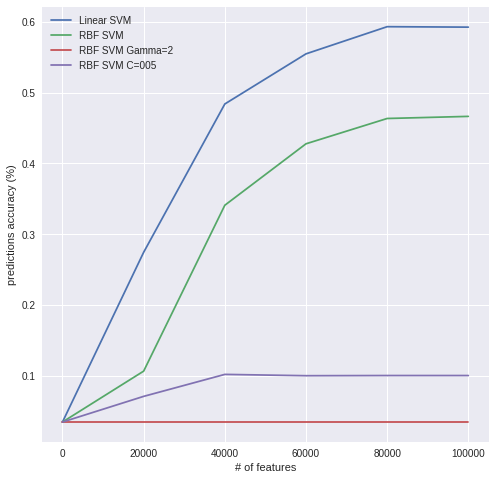

In [0]:
X_train_features_resnet50 = feature_extraction_resnet50(X_train[0:400], model_resnet50)
testClassifiers(X_train_features_resnet50[0:400], y_train[0:400].ravel(), 20000)

# Extração de features com Inception V3 (Imagenet)

Treinamento de diversos modelos de SVMs sobre as features extraídas pela rede Inception V3 [Szegedy et al, 2015](https://arxiv.org/abs/1512.00567) pré-treinada para classificação no Imagenet, variando a quantidade de features utilizadas.

### Instanciar a rede

In [0]:
from keras.applications import inception_v3

model_inception_v3 = inception_v3.InceptionV3(weights='imagenet', include_top = False)
model_inception_v3.summary()

87916544/87910968 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_50 (Activation)      (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________

### Funções para extrair as *Inception V3 features* das imagens


In [0]:
def get_features_inception_v3(img, model, new_sz):
    img = np.stack((img,)*3, axis=-1)
    pimage = Image.fromarray(img.astype('uint8'))
    pimage = pimage.resize((new_sz,new_sz))
    img_data = image.img_to_array(pimage)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input_inceptionV3(img_data)
    features = model.predict(img_data)
    return features
  
def feature_extraction_inception_v3(X, model):
    M = []
    for i in tqdm(range(len(X)), desc="Extracting image features using Inception V3"):
        features = get_features_resnet50(X[i].reshape(28,28), model, 224)
        feature_np = np.array(features)
        M.append(feature_np.flatten())
    M = np.asarray(M)
    print(M.shape)
    return M

### Extrair as *Inception V3 features* e avaliar os classificadores

Evaluating Linear SVM...:   0%|          | 0/3 [00:00<?, ?it/s]

(400, 51200)

>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:  33%|███▎      | 1/3 [00:00<00:00,  9.27it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   0%|          | 0/3 [00:00<?, ?it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   0%|          | 0/3 [00:00<?, ?it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 3/3 [01:09<00:00, 22.00s/it]


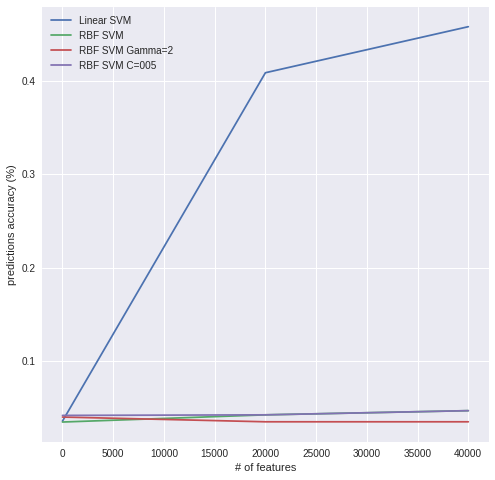

In [0]:
X_train_features_inception_v3 = feature_extraction_inception_v3(X_train[0:400], model_inception_v3)
testClassifiers(X_train_features_inception_v3[0:400], y_train[0:400].ravel(), 20000)

# Componentes PCA

Obter os 100 primeiros componentes PCA da imagem e das features extraídas das redes neurais e avaliar os SVMs da mesma forma que anteriormente.

In [0]:
n_components = 100

### PCA nos pixels das imagens

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
Evaluating Linear SVM...:   0%|          | 0/10 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:  20%|██        | 2/10 [00:00<00:00, 11.00it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:  20%|██        | 2/10 [00:00<00:00, 12.74it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:  20%|██        | 2/10 [00:00<00:00, 14.75it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 10/10 [00:01<00:00,  7.54it/s]


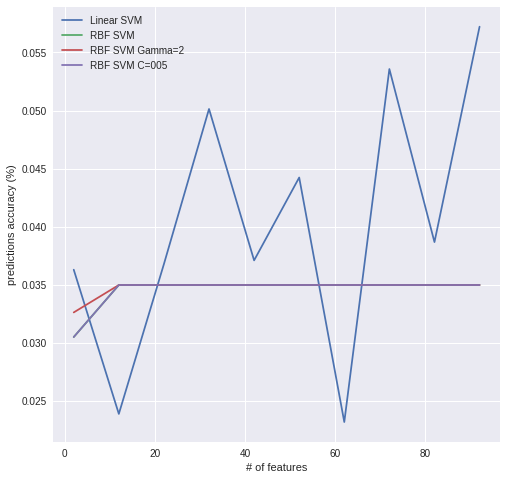

In [0]:
shape = X_train.shape

PCA_X_train = X_train.reshape(shape[0], np.prod(shape[1:]))
pca = RandomizedPCA(n_components = n_components).fit(PCA_X_train)
pca_train = pca.transform(PCA_X_train)

testClassifiers(pca_train[0:400], y_train[0:400].ravel(), 10)

### PCA nas  *VGG16 features*

Extracting image features using VGG16:   0%|          | 0/400 [00:00<?, ?it/s]

0


Extracting image features using VGG16: 100%|██████████| 400/400 [00:11<00:00, 34.05it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


(400, 25088)


Evaluating Linear SVM...:   0%|          | 0/10 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:  10%|█         | 1/10 [00:00<00:01,  8.20it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:  20%|██        | 2/10 [00:00<00:00, 11.97it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:  20%|██        | 2/10 [00:00<00:00, 14.33it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


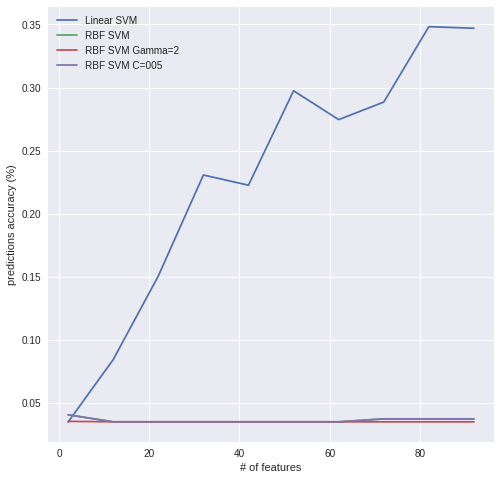

In [0]:
shape = X_train_features_vgg.shape

PCA_X_train = X_train_features_vgg.reshape(shape[0],np.prod(shape[1:]))
pca = RandomizedPCA(n_components=n_components).fit(PCA_X_train)
pca_train = pca.transform(PCA_X_train)

testClassifiers(pca_train[0:400], y_train[0:400].ravel(), 10)

### PCA nas *Resnet50 features*

Extracting image features using Resnet50: 100%|██████████| 400/400 [00:13<00:00, 29.65it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


(400, 100352)


Evaluating Linear SVM...:   0%|          | 0/10 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:  20%|██        | 2/10 [00:00<00:00, 11.37it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:  20%|██        | 2/10 [00:00<00:00, 12.79it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:  20%|██        | 2/10 [00:00<00:00, 14.22it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


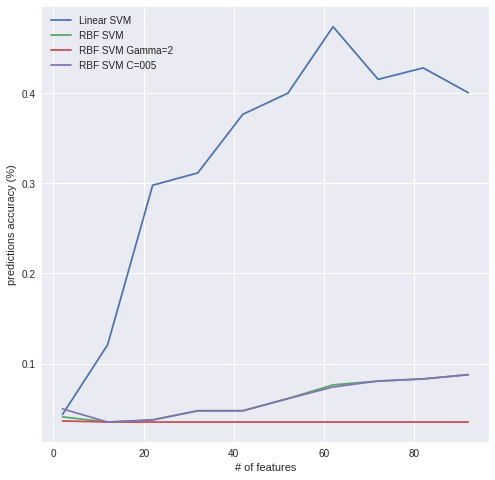

In [0]:
shape = X_train_features_resnet50.shape

PCA_X_train = X_train_features_resnet50.reshape(shape[0],np.prod(shape[1:]))
pca = RandomizedPCA(n_components=n_components).fit(PCA_X_train)
pca_train = pca.transform(PCA_X_train)

testClassifiers(pca_train[0:400], y_train[0:400].ravel(), 10)

### PCA nas *Inception V3 features*

Extracting image features using Inception V3: 100%|██████████| 400/400 [00:17<00:00, 29.00it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


(400, 51200)


Evaluating Linear SVM...:   0%|          | 0/50 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:   4%|▍         | 2/50 [00:00<00:03, 12.38it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   4%|▍         | 2/50 [00:00<00:03, 13.43it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   4%|▍         | 2/50 [00:00<00:03, 15.05it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 50/50 [00:05<00:00,  6.12it/s]


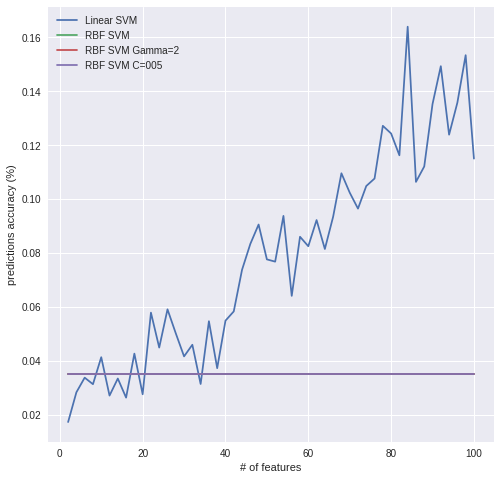

In [0]:
X_train_features_inception_v3 = feature_extraction_inception_v3(X_train[0:400], model_inception_v3)
shape = X_train_features_inception_v3.shape

PCA_X_train = X_train_features_inception_v3.reshape(shape[0],np.prod(shape[1:]))
pca = RandomizedPCA(n_components=n_components).fit(PCA_X_train)
pca_train = pca.transform(PCA_X_train)

testClassifiers(pca_train[0:400], y_train[0:400].ravel(), 2)

# Extração de features com VGG19 (EMNIST)

Treinamento de diversos modelos de SVMs sobre as features extraídas pela rede VGG19 [(Simonyan et al, 2015)](https://arxiv.org/abs/1409.1556), pré-treinada para classificação no próprio EMNIST, variando a quantidade de features utilizadas.

In [0]:
NUM_TESTS = 2000

In [0]:
vgg_model_file_id = '1iLgU3mm2Rsdh3Q9xXi_pttajhdXUfswB'
vgg_model_file = drive.CreateFile({'id': vgg_model_file_id})
vgg_model_file.GetContentFile('emnist_adam_vgg_normal.h5')

In [0]:
import keras

from keras.models import Model
from keras.models import load_model

vgg_emnist_model = keras.models.load_model('emnist_adam_vgg_normal.h5')
vgg_emnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [0]:
layer_name_vgg = 'flatten_1'
intermediate_layer_model_vgg = Model(inputs=vgg_emnist_model.input,
                                 outputs=vgg_emnist_model.get_layer(layer_name_vgg).output)

In [0]:
from keras.applications import vgg16

def get_features_emnist_vgg(img, model, new_sz):
    img = np.stack((img,)*3, axis=-1)
    pimage = Image.fromarray(img.astype('uint8'))
    pimage = pimage.resize((new_sz,new_sz))
    img_data = image.img_to_array(pimage)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = vgg16.preprocess_input(img_data)
    features = model.predict(img_data)
    return features
  
def feature_extraction_emnist_vgg(X, model):
    M = []
    for i in tqdm(range(len(X)), desc="Extracting image features using VGG"):
        features = get_features_emnist_vgg(X[i].reshape(28,28), model, 32)
        feature_np = np.array(features)
        M.append(feature_np.flatten())
    M = np.asarray(M)
    print(M.shape)
    return M

In [0]:
X_train_features_emnist_vgg = feature_extraction_emnist_vgg(X_train[0:NUM_TESTS], intermediate_layer_model_vgg)

Extracting image features using VGG: 100%|██████████| 2000/2000 [00:21<00:00, 91.69it/s] 

(2000, 512)


Evaluating Linear SVM...:   0%|          | 0/4 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:   0%|          | 0/4 [00:00<?, ?it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   0%|          | 0/4 [00:00<?, ?it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   0%|          | 0/4 [00:00<?, ?it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 4/4 [00:20<00:00,  5.08s/it]


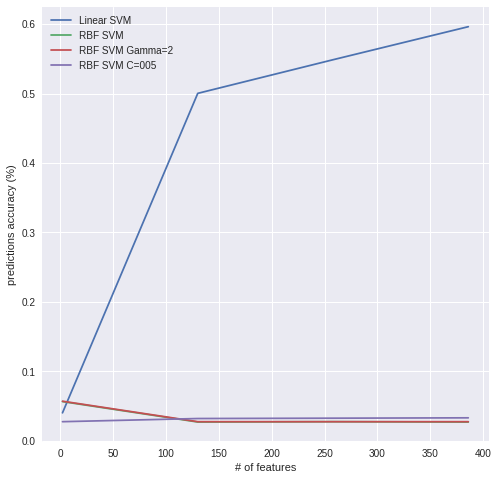

In [0]:
testClassifiers(X_train_features_emnist_vgg[0:NUM_TESTS], y_train[0:NUM_TESTS].ravel(), 128)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
Evaluating Linear SVM...:   0%|          | 0/10 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:   0%|          | 0/10 [00:00<?, ?it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   0%|          | 0/10 [00:00<?, ?it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   0%|          | 0/10 [00:00<?, ?it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 10/10 [00:17<00:00,  2.33s/it]


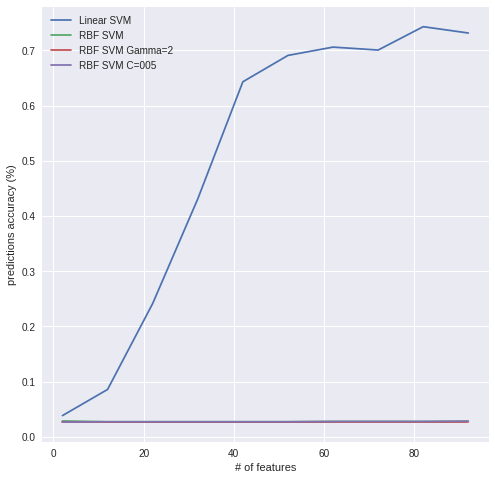

In [0]:
shape = X_train_features_emnist_vgg.shape

PCA_X_train = X_train_features_emnist_vgg.reshape(shape[0],np.prod(shape[1:]))
pca = RandomizedPCA(n_components=n_components).fit(PCA_X_train)
pca_train = pca.transform(PCA_X_train)

testClassifiers(pca_train[0:NUM_TESTS], y_train[0:NUM_TESTS].ravel(), 10)

# Extração de features com Resnet50 (EMNIST)

Treinamento de diversos modelos de SVMs sobre as features extraídas pela rede Resnet50 [(He et al, 2015)](https://arxiv.org/abs/1512.03385) pré-treinada para classificação no próprio EMNIST, variando a quantidade de features utilizadas.

In [0]:
resnet_model_file_id = '1yWhaynQiuyK96QJoGy6aq-ZQb6-cJrsg'
resnet_model_file = drive.CreateFile({'id': resnet_model_file_id})
resnet_model_file.GetContentFile('emnist_adam_resnet.h5')

In [0]:
model_resnet50_emnist = keras.models.load_model('emnist_adam_resnet.h5')
model_resnet50_emnist.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
layer_name = 'flatten_2'
intermediate_layer_model_resnet50 = Model(inputs=model_resnet50_emnist.input,
                                 outputs=model_resnet50_emnist.get_layer(layer_name).output)

In [0]:
def get_features_emnist_resnet50(img, model, new_sz):
    img = np.stack((img,)*3, axis=-1)
    pimage = Image.fromarray(img.astype('uint8'))
    pimage = pimage.resize((new_sz,new_sz))
    img_data = image.img_to_array(pimage)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = resnet50.preprocess_input(img_data)
    features = model.predict(img_data)
    return features
  
def feature_extraction_emnist_resnet50(X, model):
    M = []
    for i in tqdm(range(len(X)), desc="Extracting image features using Resnet50"):
        features = get_features_emnist_resnet50(X[i].reshape(28,28), model, 32)
        feature_np = np.array(features)
        M.append(feature_np.flatten())
    M = np.asarray(M)
    print(M.shape)
    return M

In [0]:
X_train_features_emnist_resnet50 = feature_extraction_emnist_resnet50(X_train[0:NUM_TESTS], intermediate_layer_model_resnet50)

Extracting image features using Resnet50: 100%|██████████| 2000/2000 [00:52<00:00, 38.45it/s]

(2000, 2048)


Evaluating Linear SVM...:   0%|          | 0/16 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:   0%|          | 0/16 [00:00<?, ?it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   0%|          | 0/16 [00:00<?, ?it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   0%|          | 0/16 [00:00<?, ?it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 16/16 [06:04<00:00, 37.65s/it]


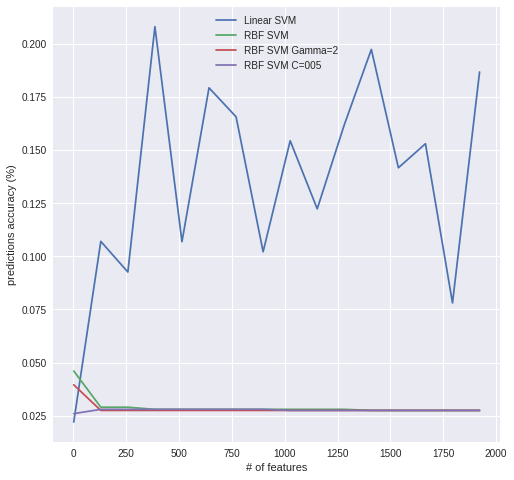

In [0]:
testClassifiers(X_train_features_emnist_resnet50[0:NUM_TESTS], y_train[0:NUM_TESTS].ravel(), 128)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
Evaluating Linear SVM...:   0%|          | 0/10 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:   0%|          | 0/10 [00:00<?, ?it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   0%|          | 0/10 [00:00<?, ?it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   0%|          | 0/10 [00:00<?, ?it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 10/10 [00:17<00:00,  2.31s/it]


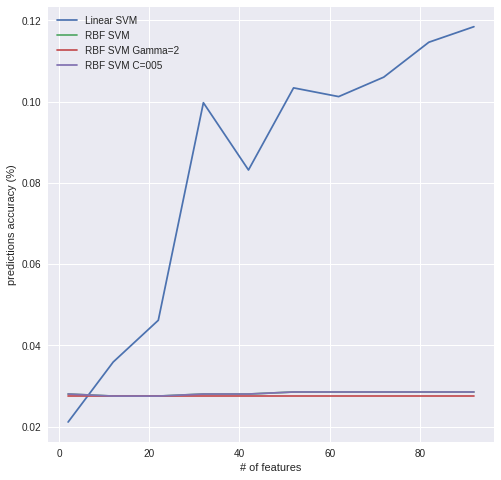

In [0]:
shape = X_train_features_emnist_resnet50.shape

PCA_X_train = X_train_features_emnist_resnet50.reshape(shape[0],np.prod(shape[1:]))
pca = RandomizedPCA(n_components=n_components).fit(PCA_X_train)
pca_train = pca.transform(PCA_X_train)

testClassifiers(pca_train[0:NUM_TESTS], y_train[0:NUM_TESTS].ravel(), 10)

# Extração de features com Mobilenet (EMNIST)

Treinamento de diversos modelos de SVMs sobrea s features extraídas pela rede Mobilenet, pré-trein'ada para classificação no próprio EMINST, variando a quantidade de features utilizadas.

In [0]:
mobileNet_model_file_id = '1Lr0HdMEKxZ4t5XkPuIP6TRs24caWAwpt'
mobilenet_model_file = drive.CreateFile({'id': mobileNet_model_file_id})
mobilenet_model_file.GetContentFile('emnist_adam_mobilenet.h5')

In [0]:
mobilenet_emnist_model = keras.models.load_model('emnist_adam_mobilenet.h5')
mobilenet_emnist_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 33, 33, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128       
__________

In [0]:
layer_name = 'flatten_3'
intermediate_layer_model_mobilenet = Model(inputs=mobilenet_emnist_model.input,
                                 outputs=mobilenet_emnist_model.get_layer(layer_name).output)

In [0]:
from keras.applications import mobilenet

def get_features_emnist_mobilenet(img, model, new_sz):
    img = np.stack((img,)*3, axis=-1)
    pimage = Image.fromarray(img.astype('uint8'))
    pimage = pimage.resize((new_sz,new_sz))
    img_data = image.img_to_array(pimage)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = mobilenet.preprocess_input(img_data)
    features = model.predict(img_data)
    return features
  
def feature_extraction_emnist_mobilenet(X, model):
    M = []
    for i in tqdm(range(len(X)), desc="Extracting image features using Mobilenet"):
        features = get_features_emnist_mobilenet(X[i].reshape(28,28), model, 32)
        feature_np = np.array(features)
        M.append(feature_np.flatten())
    M = np.asarray(M)
    print(M.shape)
    return M

X_train_features_emnist_mobilenet = feature_extraction_emnist_mobilenet(X_train[0:NUM_TESTS], intermediate_layer_model_resnet50)


Extracting image features using Mobilenet: 100%|██████████| 2000/2000 [00:47<00:00, 41.82it/s]

(2000, 2048)


Evaluating Linear SVM...:   0%|          | 0/16 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:   0%|          | 0/16 [00:00<?, ?it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   0%|          | 0/16 [00:00<?, ?it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   0%|          | 0/16 [00:00<?, ?it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 16/16 [06:01<00:00, 37.45s/it]


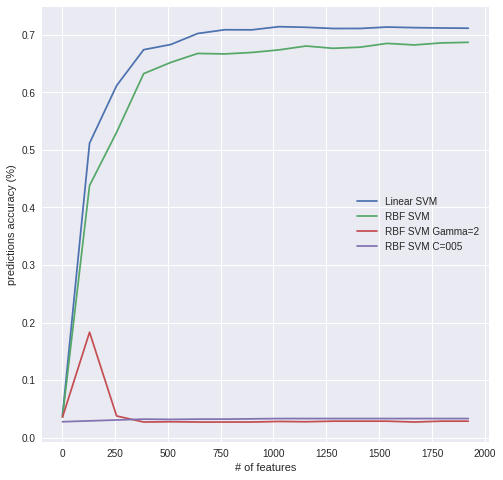

In [0]:
testClassifiers(X_train_features_emnist_mobilenet[0:NUM_TESTS], y_train[0:NUM_TESTS].ravel(), 128)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
Evaluating Linear SVM...:   0%|          | 0/10 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:   0%|          | 0/10 [00:00<?, ?it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   0%|          | 0/10 [00:00<?, ?it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   0%|          | 0/10 [00:00<?, ?it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 10/10 [00:19<00:00,  2.49s/it]


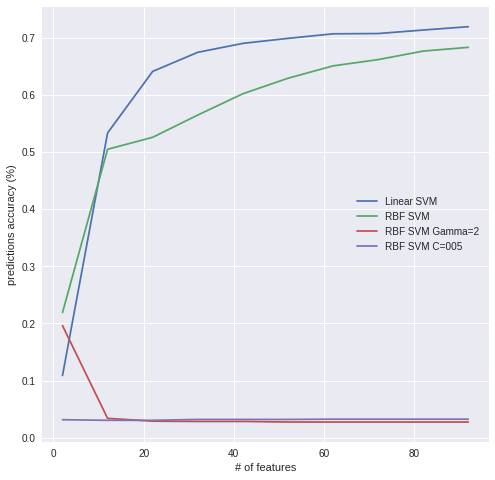

In [0]:
shape = X_train_features_emnist_mobilenet.shape

PCA_X_train = X_train_features_emnist_mobilenet.reshape(shape[0],np.prod(shape[1:]))
pca = RandomizedPCA(n_components=n_components).fit(PCA_X_train)
pca_train = pca.transform(PCA_X_train)

testClassifiers(pca_train[0:NUM_TESTS], y_train[0:NUM_TESTS].ravel(), 10)

# **Extração de features com Inception V3 (EMNIST)**

Treinamento de diversos modelos de SVMs sobrea s features extraídas pela rede Inception V3, pré-trein'ada para classificação no próprio EMINST, variando a quantidade de features utilizadas.

In [0]:
inception_model_file_id = '1TNx9a9UxBSlsq8Zwf7a0PEreeMp6N3By'
inception_model_file = drive.CreateFile({'id': inception_model_file_id})
inception_model_file.GetContentFile('emnist_adam_inception.h5')

In [0]:
import keras

inception_emnist_model = keras.models.load_model('emnist_adam_inception.h5')
inception_emnist_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_472 (Conv2D)             (None, 63, 63, 32)   864         input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_460 (BatchN (None, 63, 63, 32)   96          conv2d_472[0][0]                 
__________________________________________________________________________________________________
activation_460 (Activation)     (None, 63, 63, 32)   0           batch_normalization_460[0][0]    
__________________________________________________________________________________________________
conv2d_473

In [0]:
layer_name = 'flatten_3'
intermediate_layer_model_inception = Model(inputs=inception_emnist_model.input,
                                 outputs=inception_emnist_model.get_layer(layer_name).output)

In [0]:
from keras.applications import inception_v3

def get_features_emnist_inceptionv3(img, model, new_sz):
    img = np.stack((img,)*3, axis=-1)
    pimage = Image.fromarray(img.astype('uint8'))
    pimage = pimage.resize((new_sz,new_sz))
    img_data = image.img_to_array(pimage)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = inception_v3.preprocess_input(img_data)
    features = model.predict(img_data)
    return features
  
def feature_extraction_emnist_inceptionv3(X, model):
    M = []
    for i in tqdm(range(len(X)), desc="Extracting image features using Inception V3"):
        features = get_features_emnist_inceptionv3(X[i].reshape(28,28), model, 128)
        feature_np = np.array(features)
        M.append(feature_np.flatten())
    M = np.asarray(M)
    print(M.shape)
    return M

X_train_features_emnist_inception_v3 = feature_extraction_emnist_inceptionv3(X_test[0:NUM_TESTS], intermediate_layer_model_inception)


Extracting image features using Inception V3: 100%|██████████| 2000/2000 [01:10<00:00, 28.20it/s]


(2000, 8192)


Evaluating Linear SVM...:  12%|█▎        | 1/8 [00:00<00:00,  8.00it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM


Evaluating RBF SVM...:   0%|          | 0/8 [00:00<?, ?it/s]

+ RBF SVM


Evaluating RBF SVM Gamma=2...:   0%|          | 0/8 [00:00<?, ?it/s]

+ RBF SVM Gamma=2


Evaluating RBF SVM C=005...:   0%|          | 0/8 [00:00<?, ?it/s]

+ RBF SVM C=005


Evaluating RBF SVM C=005...: 100%|██████████| 8/8 [11:57<00:00, 124.47s/it]


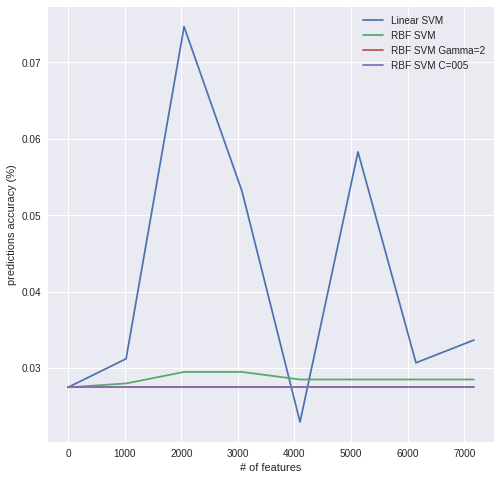

In [0]:
testClassifiers(X_train_features_emnist_inception_v3[0:NUM_TESTS], y_test[0:NUM_TESTS].ravel(), 1024)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)

Evaluating Linear SVM...:   0%|          | 0/10 [00:00<?, ?it/s]


>> Classifiers
cross validation, kfolds =  4 

+ Linear SVM



Evaluating Linear SVM...: 100%|██████████| 10/10 [02:29<00:00, 21.41s/it]

Evaluating RBF SVM...:  10%|█         | 1/10 [00:00<00:00,  9.72it/s]

+ RBF SVM



Evaluating RBF SVM...: 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]

Evaluating RBF SVM Gamma=2...:  20%|██        | 2/10 [00:00<00:00, 11.00it/s]

+ RBF SVM Gamma=2



Evaluating RBF SVM Gamma=2...: 100%|██████████| 10/10 [00:01<00:00,  6.11it/s]

Evaluating RBF SVM C=005...:  20%|██        | 2/10 [00:00<00:00, 12.85it/s]

+ RBF SVM C=005



Evaluating RBF SVM C=005...: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


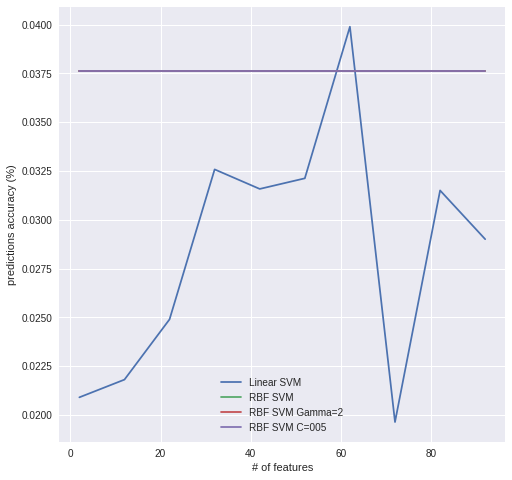

In [0]:
shape = X_train_features_emnist_inception_v3.shape

PCA_X_train = X_train_features_emnist_inception_v3.reshape(shape[0],np.prod(shape[1:]))
pca = RandomizedPCA(n_components=n_components).fit(PCA_X_train)
pca_train = pca.transform(PCA_X_train)

testClassifiers(pca_train[0:NUM_TESTS], y_test[0:NUM_TESTS].ravel(), 10)